In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#!pip install pandas
#!pip install tqdm

#!pip install scipy
#!pip install matchms
#!pip install scikit-learn
#!pip install spec2vec
#!pip install seaborn

In [3]:
import os
os.chdir('/Users/sebas/projects/metabolomics')
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [4]:
from src.transformers.sklearn_model import SklearnModel

In [5]:
import gensim
from src.load_data import LoadData
from src.config import Config
from matchms import calculate_scores
from matchms.importing import load_from_mgf,load_from_msp
import matchms.filtering as msfilters
from spec2vec import SpectrumDocument
from torch.utils.data import DataLoader, WeightedRandomSampler
from spec2vec.model_building import train_new_word2vec_model
from tqdm import tqdm
from src.loader_saver import LoaderSaver
import itertools
from pytorch_lightning.callbacks import ProgressBar
from src.losscallback import LossCallback
import numpy as np
from matchms.importing import load_from_msp
from matchms.similarity import ModifiedCosine
from scipy.stats import spearmanr
import dill
from src.weight_sampling import WeightSampling
from src.plotting import Plotting
from torch.utils.data import DataLoader, WeightedRandomSampler
import lightning.pytorch as pl
from src.load_data import LoadData
from sklearn.model_selection import train_test_split
from src.train_utils import TrainUtils
from src.preprocessor import Preprocessor
from matchms.filtering import add_fingerprint
import pickle
import sys
from src.config import Config
from src.parser import Parser
from datetime import datetime
from src.loader_saver import LoaderSaver
from src.spec2vec_comparison import Spec2VecComparison
from src.ms2deepscore_comparison import MS2DeepScoreComparison
from src.molecule_pairs_opt import MoleculePairsOpt
from scipy.stats import spearmanr
from src.transformers.load_data import LoadData as LoadDataTrans
from src.transformers.load_data_unique import LoadDataUnique

In [6]:
from src.transformers.embedder import Embedder

In [7]:
ls /Users/sebas/projects/data

ALL_GNPS_NO_PROPOGATED_wb.mgf
GNPS-NIH-NATURALPRODUCTSLIBRARY.mgf
all_spectrums_gnps.pkl
all_spectrums_gnps_nist_20240130_gnps_nist_janssen.pkl
all_spectrums_janssen.pkl
all_spectrums_nist.pkl
best_model.ckpt
best_model_128n_10_layers_20240209.ckpt
best_model_128n_5_layers_20240219_elementwise.ckpt
best_model_128n_5_layers_20240229.ckpt
best_model_128n_5_layers_20240303.ckpt
best_model_20240301.ckpt
drug_plus.mgf
hr_msms_nist_all.MSP*
hr_msms_nist_sample.MSP
merged_gnps_nist_20240118_gnps_nist_janssen.pkl
merged_gnps_nist_20240207_gnps_nist_janssen_15_millions.pkl
merged_gnps_nist_20240227_gnps_nist_janssen_20_millions_OUTSIDE_MAX_DIFF_NO_JANSSEN.pkl
merged_gnps_nist_20240311_unique_smiles_1million.pkl
ms2deepscore_positive_10k_1000_1000_1000_500.hdf5
spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model
spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model.trainables.syn1neg.npy
spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model.wv.vectors.npy
to_export_gnps_nist.pkl

## Parameters

In [8]:
data_folder= '/Users/sebas/projects/data/'
dataset_path = data_folder + 'uniformed_molecule_pairs_test.pkl'
gnps_path =  data_folder + 'ALL_GNPS_NO_PROPOGATED_wb.mgf'
janssen_path = data_folder + 'drug_plus.mgf'
nist_path = data_folder + 'hr_msms_nist_all.MSP'
output_pairs_file= data_folder + 'molecular_pairs.pkl'
output_nist_file= data_folder + 'all_spectrums_nist.pkl'
output_gnps_file= data_folder + 'all_spectrums_gnps.pkl'
output_janssen_file= data_folder + 'all_spectrums_janssen.pkl'
model_spec2vec_file = data_folder + 'spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model'
model_ms2d_file= data_folder + 'ms2deepscore_positive_10k_1000_1000_1000_500.hdf5'
#uniformed_molecule_pairs_test_path= data_folder +'uniformed_molecule_pairs_test.pkl'
#uniformed_molecule_pairs_test_path= data_folder +'merged_gnps_nist_20240207_gnps_nist_janssen_15_millions.pkl'
uniformed_molecule_pairs_test_path= data_folder + 'merged_gnps_nist_20240311_unique_smiles_1million.pkl'
transformer_path = data_folder + 'best_model_128n_5_layers_20240219_elementwise.ckpt'

In [9]:
THRESHOLD_ANALOG=0.7

In [10]:
load_molecule_pairs_file= True
only_use_gnps=False

In [11]:
## Load spectrum using spectrumutils

In [12]:
config=Config()

In [13]:
config.CHECKPOINT_DIR = './notebooks/cosine/results'
config.use_cosine_distance=True

In [14]:
NUMBER_TRAIN_PAIRS=10000

## Load molecular pairs

In [15]:
uniformed_molecule_pairs_test_path

'/Users/sebas/projects/data/merged_gnps_nist_20240311_unique_smiles_1million.pkl'

In [16]:

if load_molecule_pairs_file:
        with open(uniformed_molecule_pairs_test_path, 'rb') as file:
            dataset = dill.load(file)


In [17]:
molecule_pairs_train= dataset['molecule_pairs_train']
molecule_pairs_val= dataset['molecule_pairs_val']

In [18]:
molecule_pairs_train

In [19]:
molecule_pairs_val

## Our model

In [20]:
from src.transformers.sklearn_model import SklearnModel

In [21]:
# Generate an array of 10 random integers between 0 and 100
random_integers_train = np.random.randint(0, len(molecule_pairs_train), NUMBER_TRAIN_PAIRS)
random_integers_val = np.random.randint(0, len(molecule_pairs_val), NUMBER_TRAIN_PAIRS)

In [22]:
#molecule_pairs_train= MolecularPairsSet(spectrums= molecule_pairs_train.spectrums, 
#                                      indexes_tani =molecule_pairs_train.indexes_tani[random_integers_train])
#molecule_pairs_val= MolecularPairsSet(spectrums= molecule_pairs_val.spectrums, 
#                                      indexes_tani =molecule_pairs_val.indexes_tani[random_integers_val])
molecule_pairs_train= MoleculePairsOpt(
            spectrums_unique=molecule_pairs_train.spectrums,
            indexes_tani_unique= molecule_pairs_train.indexes_tani[random_integers_train],
            spectrums_original=molecule_pairs_train.spectrums_original,
            df_smiles=molecule_pairs_train.df_smiles,
        )
molecule_pairs_val= MoleculePairsOpt(
            spectrums_unique=molecule_pairs_val.spectrums,
            indexes_tani_unique= molecule_pairs_val.indexes_tani[random_integers_val],
            spectrums_original=molecule_pairs_val.spectrums_original,
            df_smiles=molecule_pairs_val.df_smiles,
        )

In [23]:
## CALCULATION OF WEIGHTS
train_binned_list, _ = TrainUtils.divide_data_into_bins(
    molecule_pairs_train, config.bins_uniformise_TRAINING,
)

In [24]:
weights, range_weights = WeightSampling.compute_weights(train_binned_list)

In [25]:
weights

array([0.0166136 , 0.00771263, 0.01353348, 0.03118583, 0.08682793,
       0.01050449, 0.03745132, 0.10853491, 0.20242093, 0.392793  ,
       0.09242188])

In [26]:
range_weights

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [27]:
weights_tr = WeightSampling.compute_sample_weights(molecule_pairs_train, weights)
weights_val = WeightSampling.compute_sample_weights(molecule_pairs_val, weights)

In [28]:
dataset_train = LoadDataUnique.from_molecule_pairs_to_dataset(molecule_pairs_train, training=True)
# dataset_test = LoadData.from_molecule_pairs_to_dataset(m_test)
dataset_val = LoadDataUnique.from_molecule_pairs_to_dataset(molecule_pairs_val)

Preprocessing all the data ...


261349it [00:04, 58194.11it/s]


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries
Preprocessing all the data ...


31318it [00:00, 77566.62it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries


In [29]:
next(iter(dataset_train))

{'mz_0': array([ 50.0148,  51.0226,  52.0179,  61.0069,  62.0147,  63.0226,
         64.0178,  64.0304,  65.0257,  65.0382,  66.0209,  66.0461,
         67.0413,  76.0178,  76.0303,  77.0131,  77.0256,  78.0334,
         79.0367,  79.0412,  88.0177,  89.0255,  90.0333,  91.0412,
         92.049 ,  93.0568,  96.0439, 102.0334, 103.0286, 103.0412,
        104.0365, 104.0491, 105.0442, 106.0282, 106.0476, 110.0595,
        115.0286, 116.0364, 117.0443, 118.0521, 119.0599, 120.0439,
        120.0631, 121.0392, 129.0443, 130.0521, 131.0361, 133.0392,
        134.0427, 135.0548, 147.0548, 148.058 , 148.0627, 163.0497,
        204.9376, 219.9249, 232.9325, 241.933 , 242.9408, 259.9433,
          0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
          0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
          0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
          0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
          0.    ,   0.    ,   0.    ,   

In [30]:
train_sampler = WeightedRandomSampler(
    weights=weights_tr, num_samples=len(dataset_train), replacement=True
)
val_sampler = WeightedRandomSampler(
    weights=weights_val, num_samples=len(dataset_val), replacement=True
)


In [31]:
dataloader_train = DataLoader(
    dataset_train, batch_size=config.BATCH_SIZE,  num_workers=10, sampler=train_sampler,
)
def worker_init_fn(
    worker_id,
):  # ensure the dataloader for validation is the same for every epoch
    seed = 42
    torch.manual_seed(seed)
    # Set the same seed for reproducibility in NumPy and Python's random module
    np.random.seed(seed)
    random.seed(seed)

dataloader_val = DataLoader(
    dataset_val,
    batch_size=config.BATCH_SIZE,
    num_workers=0,
    sampler=val_sampler,
)


In [32]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=config.CHECKPOINT_DIR,
    filename="best_model",
    monitor="validation_loss_epoch",
    mode="min",
    save_top_k=1,
)

# checkpoint_callback = SaveBestModelCallback(file_path=config.best_model_path)
progress_bar_callback = ProgressBar()

# loss callback
losscallback = LossCallback(file_path=config.CHECKPOINT_DIR + f"loss.png")

print("define model")


    
model = Embedder(
        d_model=int(config.D_MODEL),
        n_layers=int(config.N_LAYERS),
        weights=None,
        lr=config.LR,
        use_cosine_distance=config.use_cosine_distance,
    )

define model


In [33]:
config.LR

0.0001

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /Users/sebas/projects/metabolomics/notebooks/cosine/results exists and is not empty.

  | Name                    | Type                             | Params
-----------------------------------------------------------------------------
0 | linear                  | Linear                           | 16.5 K
1 | linear_regression       | Linear                           | 129   
2 | fixed_linear_regression | FixedLinearRegression            | 129   
3 | relu                    | ReLU                             | 0     
4 | spectrum_encoder        | SpectrumTransformerEncoderCustom | 1.7 M 
5 | regression_loss         | MSELoss                          | 0     
6 | dropout                 | Dropou

Sanity Checking: |                                                                                            …

/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
The operator 'aten::_nested_tensor_from_mask_left_aligned' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
To copy constr

Train loss:
[]
Validation loss
[0.3655490577220917]


/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Train loss:
[]
Validation loss
[0.3655490577220917, 0.1528150886297226]


Validation: |                                                                                                 …

Train loss:
[0.094134122133255]
Validation loss
[0.3655490577220917, 0.1528150886297226, 0.14133617281913757]


Validation: |                                                                                                 …

Train loss:
[0.094134122133255, 0.08125634491443634]
Validation loss
[0.3655490577220917, 0.1528150886297226, 0.14133617281913757, 0.1363883763551712]


`Trainer.fit` stopped: `max_epochs=3` reached.


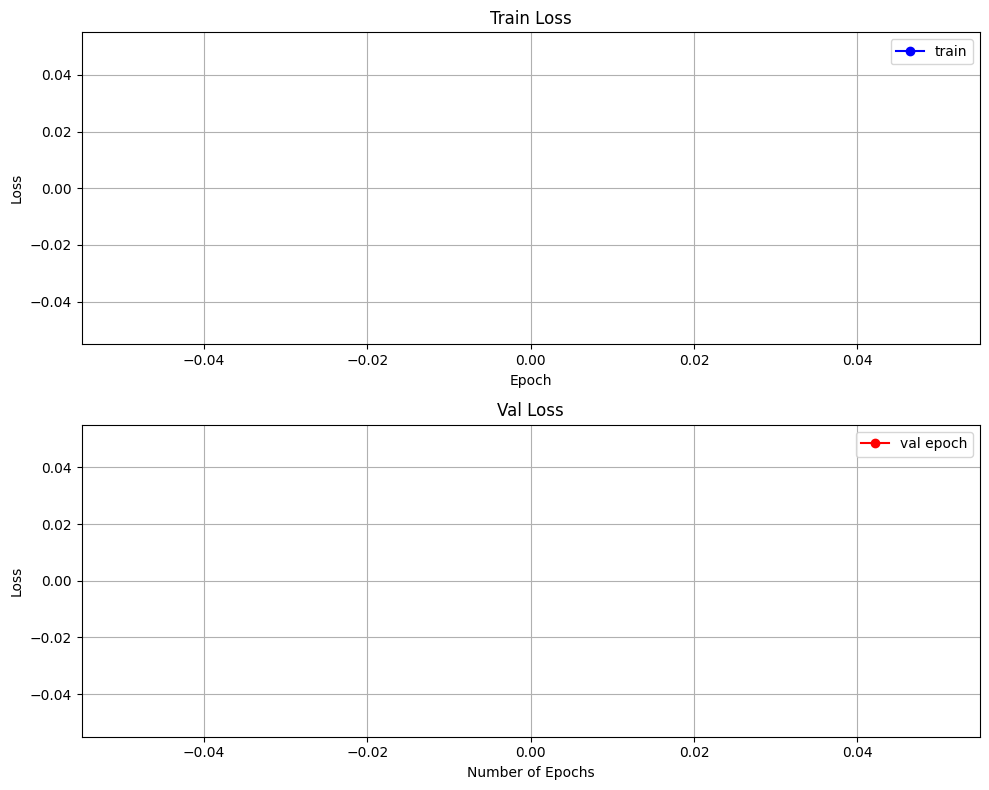

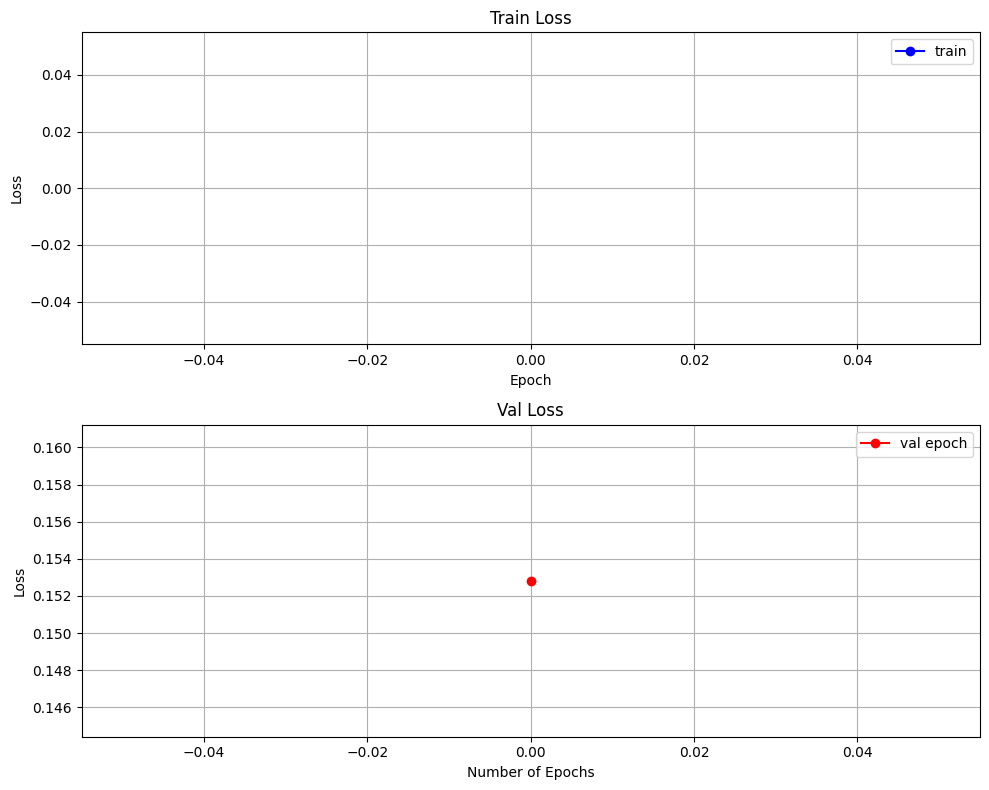

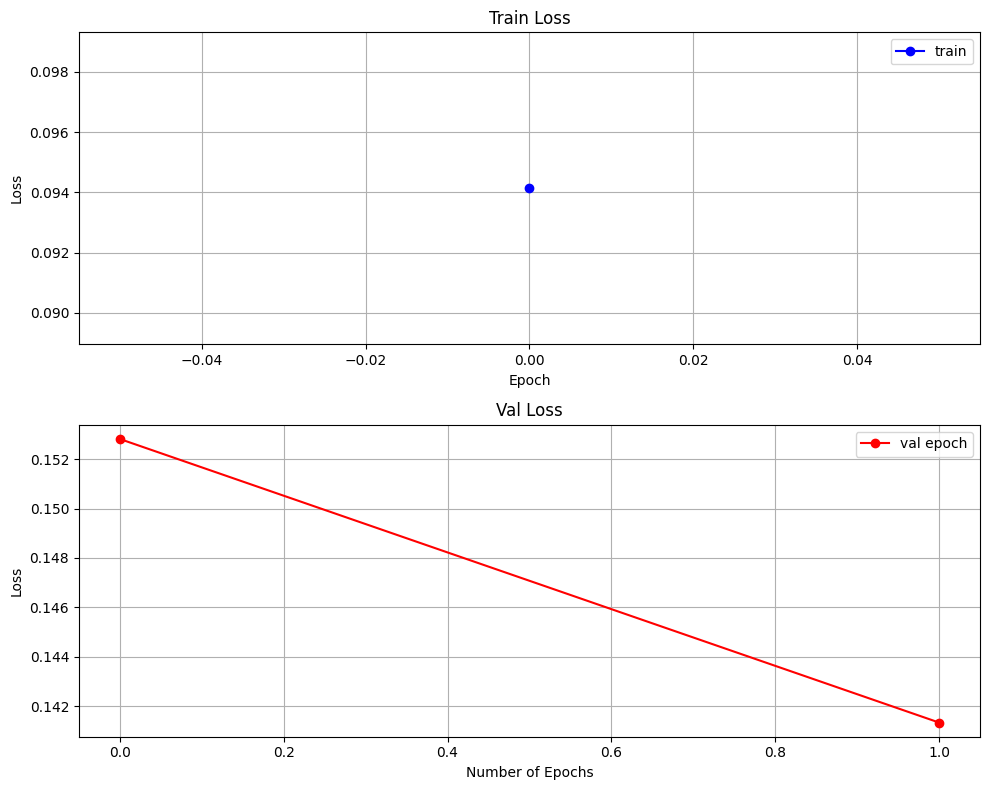

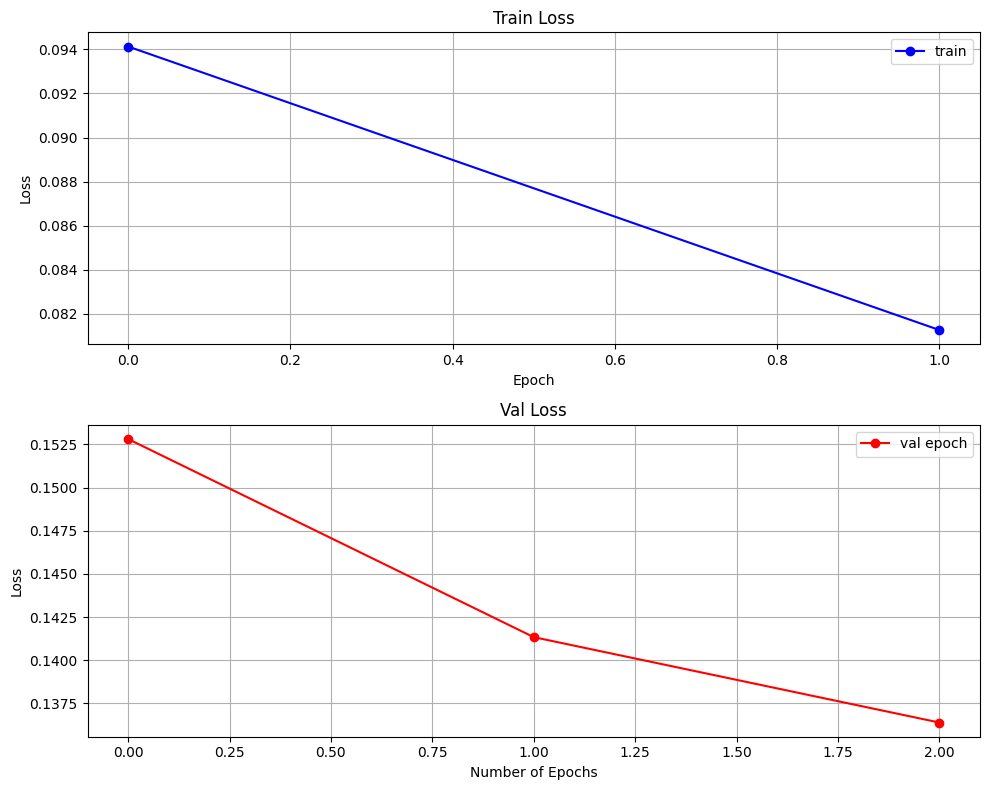

In [34]:
trainer = pl.Trainer(
    max_epochs=3,
    callbacks=[checkpoint_callback, losscallback],
    enable_progress_bar=True,
    # val_check_interval= config.validate_after_ratio,
)
# trainer = pl.Trainer(max_steps=100,  callbacks=[checkpoint_callback, losscallback], enable_progress_bar=enable_progress_bar)
trainer.fit(
    model=model,
    train_dataloaders=(dataloader_train),
    val_dataloaders=dataloader_val,
)

In [35]:
for name, param in model.named_parameters():
    print(name)
    print(param)

linear.weight
Parameter containing:
tensor([[ 0.0090, -0.0036,  0.0335,  ..., -0.0420,  0.0069,  0.0462],
        [-0.0316, -0.0346, -0.0222,  ..., -0.0396,  0.0668, -0.0536],
        [ 0.0727,  0.0469, -0.0409,  ..., -0.0764,  0.0392,  0.0407],
        ...,
        [-0.0191, -0.0803,  0.0413,  ...,  0.0649, -0.0602, -0.0050],
        [-0.0193, -0.0827, -0.0529,  ..., -0.0762,  0.0758,  0.0057],
        [-0.0443,  0.0590, -0.0588,  ...,  0.0448, -0.0727,  0.0142]],
       requires_grad=True)
linear.bias
Parameter containing:
tensor([-1.4444e-02, -4.1921e-02, -4.9954e-02, -1.4236e-02,  4.1797e-02,
         4.5884e-02,  8.0548e-02,  8.7795e-02,  3.7655e-02,  6.0488e-02,
         3.0629e-02,  4.3377e-02, -2.3590e-03,  7.2923e-02,  5.8810e-02,
         1.2782e-02,  8.7213e-02, -6.1500e-02, -4.8630e-02,  1.1185e-02,
        -3.8322e-02,  3.0941e-02, -8.2509e-02,  5.5744e-02, -5.8366e-02,
        -8.3612e-02, -5.5490e-03,  4.8119e-02,  3.4150e-02,  8.5440e-02,
        -5.1083e-02, -1.6375e-0